In [60]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from ipywidgets import interact
from IPython.display import display, HTML
import os
import pandas as pd

def getFiles(path, kind='csv'):
    kind = '.'+kind
    fn = len(kind)
    filenames = []
    for root, dirs, files in os.walk(path):
        for f in files:
            if f[-fn:] == kind:
                filenames.append(os.path.join(root, f))
    print('Total number of {0} files: '.format(kind[1:]), len(filenames))
    return filenames 

dx = 0.156
dt = 1./15.

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Data
The data consists of tracks from 27 different videos of wild type (WT) Salmonella in mouse GI mucus. An example is seen in the video below.

Note that the x, y positions are given in pixel coordinates and t is given in frames. The conversion to physical units is `dx=0.156` micrometers and `dt=0.0667` seconds.

### Our paper
https://www.nature.com/articles/s41385-020-0267-9.pdf?origin=ppub

In [61]:
HTML("""<video width="512" height="512" 
controls autoplay loop 
src="Videos/160706_WT_Q/Duodenum/160706_WT_Q_Duodenum_NoAbAdded_1.mp4">
""")

## Get a list of all CSV files in the 'Tracks' folder (including subfolders)

In [62]:
files = getFiles('./Tracks')
files

Total number of csv files:  27


['./Tracks\\160706_WT_Q\\Duodenum\\160706_WT_Q_Duodenum_NoAbAdded_1.csv',
 './Tracks\\160706_WT_Q\\Duodenum\\160706_WT_Q_Duodenum_NoAbAdded_2.csv',
 './Tracks\\160706_WT_Q\\Duodenum\\160706_WT_Q_Duodenum_NoAbAdded_3.csv',
 './Tracks\\160706_WT_Q\\Duodenum\\160706_WT_Q_Duodenum_NoAbAdded_4.csv',
 './Tracks\\160706_WT_Q\\Duodenum\\160706_WT_Q_Duodenum_NoAbAdded_5.csv',
 './Tracks\\160706_WT_Q\\Duodenum\\160706_WT_Q_Duodenum_NoAbAdded_6.csv',
 './Tracks\\160706_WT_Q\\Duodenum\\160706_WT_Q_Duodenum_NoAbAdded_7.csv',
 './Tracks\\160706_WT_Q\\Duodenum\\160706_WT_Q_Duodenum_NoAbAdded_8.csv',
 './Tracks\\160706_WT_Q\\Duodenum\\160706_WT_Q_Duodenum_NoAbAdded_9.csv',
 './Tracks\\160706_WT_Q\\Ileum\\160706_WT_Q_Ileum_NoAbAdded_1.csv',
 './Tracks\\160706_WT_Q\\Ileum\\160706_WT_Q_Ileum_NoAbAdded_10.csv',
 './Tracks\\160706_WT_Q\\Ileum\\160706_WT_Q_Ileum_NoAbAdded_11.csv',
 './Tracks\\160706_WT_Q\\Ileum\\160706_WT_Q_Ileum_NoAbAdded_2.csv',
 './Tracks\\160706_WT_Q\\Ileum\\160706_WT_Q_Ileum_NoAbAdded_

## Example of loading one file using Pandas

In [63]:
print(files[0])
tracks = pd.read_csv(files[0])
tracks

./Tracks\160706_WT_Q\Duodenum\160706_WT_Q_Duodenum_NoAbAdded_1.csv


,particle,x,y,t
0,0,427.157990,69.356270,0
1,0,427.128143,69.407196,1
2,0,427.823242,69.605103,2
3,0,428.761810,69.373314,3
4,0,429.097839,69.330559,4
...,...,...,...,...
6884,177,72.843880,302.419403,1
6885,177,71.644104,302.225586,2
6886,177,68.325912,302.401917,3
6887,177,66.517029,302.887817,4


## Extract the first track

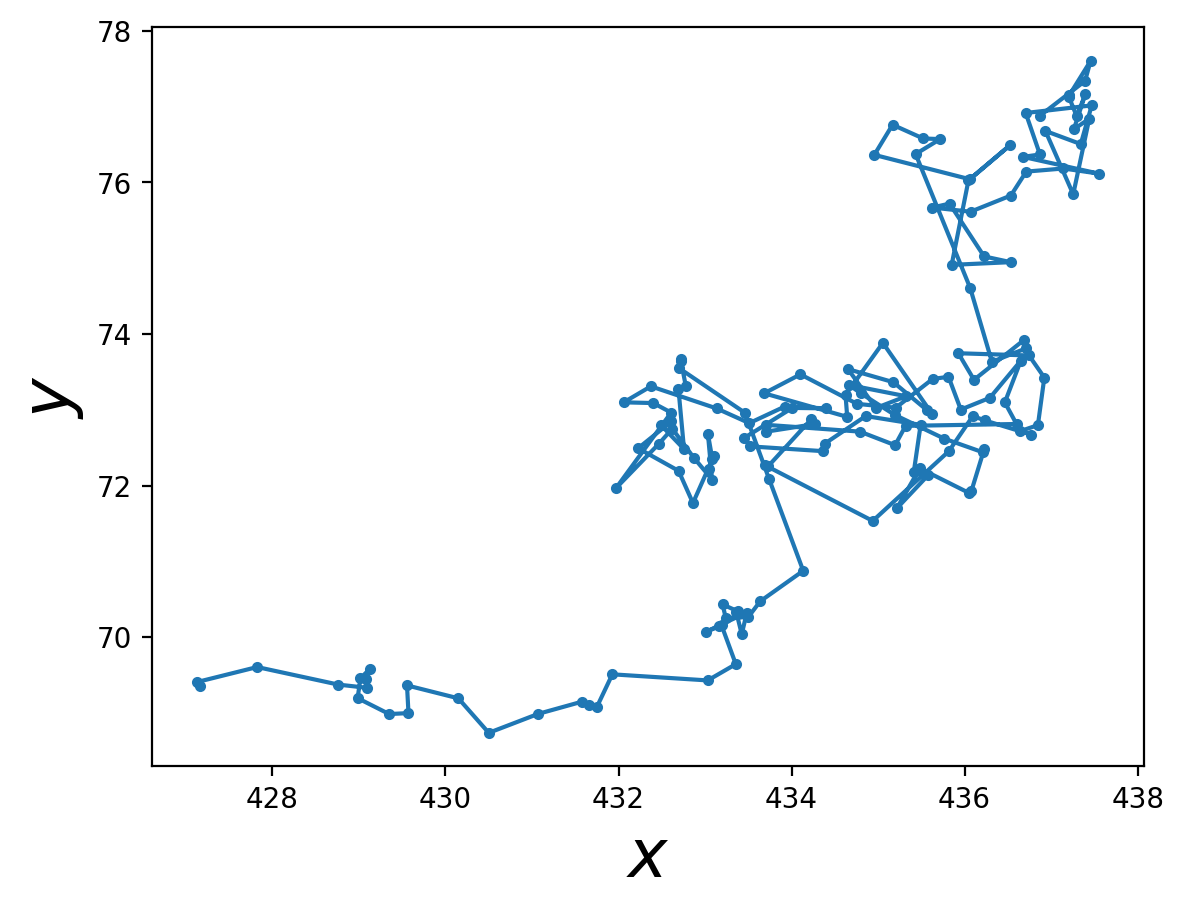

In [64]:
track = tracks[tracks.particle==0]
plot(track.x, track.y, '.-')
xlabel(r'$x$', fontsize=24)
ylabel(r'$y$', fontsize=24);

## Example of iterating over all tracks with the DataFrame `.groupby()` method

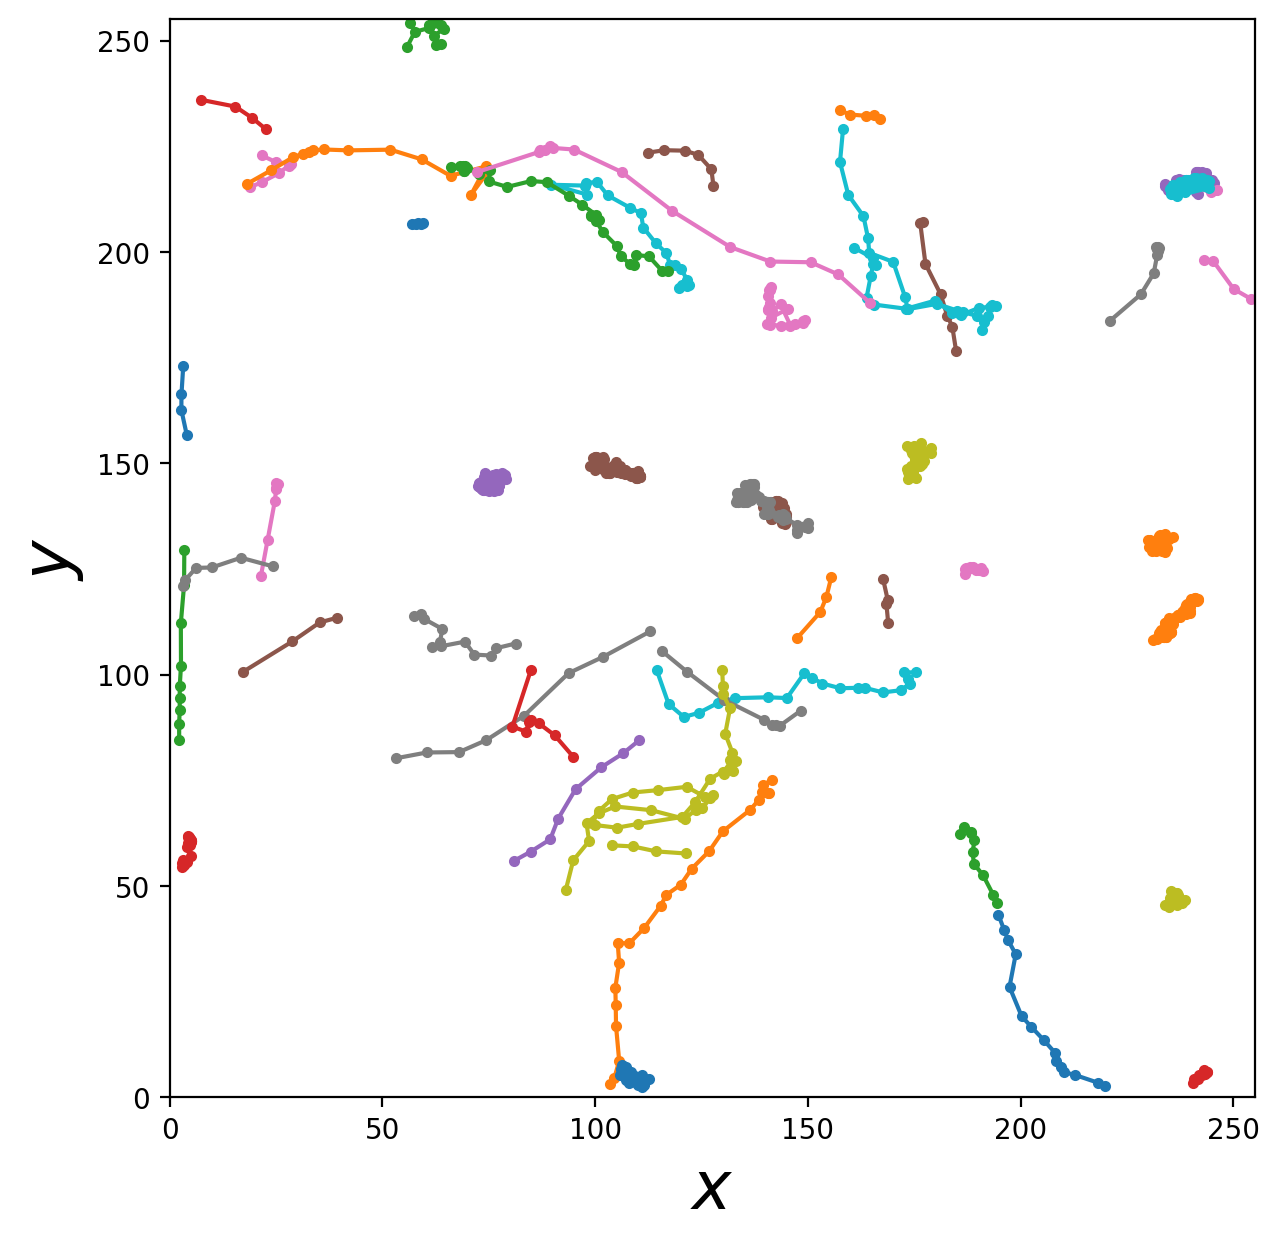

In [65]:
figure(1, [7, 7])
for track_number, track in tracks.groupby('particle'):
    plot(track.x, track.y, '.-')
xlim(0, 255)
ylim(0, 255)
xlabel(r'$x$', fontsize=24)
ylabel(r'$y$', fontsize=24);

# Goal 1: Estimate swim speed
Assume that while swimming individual Salmonella all swim at the same average speed and that the speed is the same regardless of what direction they happen to be swimming. Using the track data, estimate the (magnitude) swim speed of Salmonella in mucus.

In [66]:
files = getFiles('./Tracks')
cc = 0
aa = 0
for file in files:
    data = pd.read_csv(file)
    for track_number, track in data.groupby('particle'):
        cc = cc + 1
        xx = track.x.diff()[1:]
        yy = track.y.diff()[1:]
        xx *= dx
        yy *= dx
        dd = np.sqrt(xx**2 + yy**2)
        ddd = dd.mean()
        ddd = ddd/dt
        aa = aa + ddd
speed = aa/cc
print("The swim speed of Salmonella in mucus: {:.2f} micrometers per second".format(speed))

Total number of csv files:  27
The swim speed of Salmonella in mucus: 7.22 micrometers per second


# Goal 2: Develop a stochastic model of Salmonella motion and predict the mean first passage time to cross a mucus barrier

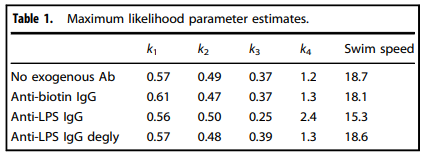

Three-State Markov Process:

The motion of bacteria is modeled using a three-state Markov process.

The three motion states are defined as follows:

Swimming: Directed motion with a random direction.

Tumbling: Undirected and diffusive motion.

Immobilized: Motion is substantially hindered and also undirected.

The model did not constrain the assignment of a smaller diffusion coefficient to the immobilized state. However, the maximum likelihood stage of the expectation-maximization algorithm selected a diffusivity that was approximately 10 times less than the tumbling state.


Parameterization:

The model includes eight parameters:

Swim speed: Magnitude of directed motion during swimming state.

Three state-specific diffusion coefficients: Reflecting the degree of random motion during tumbling and immobilized states.

Four transition rates: Governing the stochastic switching between the three motion states.

Transitions between states are allowed bidirectionally between the immobilized and hindered states, as well as between the hindered and swimming states.

Model Implementation:

Motion in the swimming state is modeled as directed, with a single speed magnitude and a three-dimensional random direction.

The random direction for swimming is selected uniformly over the unit sphere upon transitioning from the hindered state to the swimming state.

# Goal 3: Estimate the fraction of cells that are mobile vs immobile